#Sentiment Analysis on Twitter US Airline Sentiment Dataset

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

tweets = pd.read_csv("/Tweets.csv")

In [0]:
df = pd.DataFrame(tweets)

In [34]:
list(df.columns.values)

['tweet_id',
 'airline_sentiment',
 'airline_sentiment_confidence',
 'negativereason',
 'negativereason_confidence',
 'airline',
 'airline_sentiment_gold',
 'name',
 'negativereason_gold',
 'retweet_count',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_location',
 'user_timezone']

In [35]:
df.shape

(14640, 15)

In [36]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


#Let Us Explore The Data

Text(0.5, 1.0, 'Count of Sentiments')

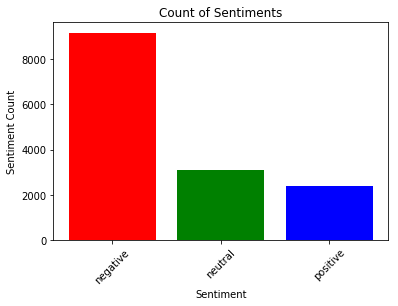

In [46]:
mood_count = df['airline_sentiment'].value_counts()
index = [1,2,3]
plt.bar(index,mood_count,color=['red', 'green', 'blue'])
plt.xticks(index,['negative','neutral','positive'],rotation=45)
plt.ylabel('Sentiment Count')
plt.xlabel('Sentiment')
plt.title('Count of Sentiments')

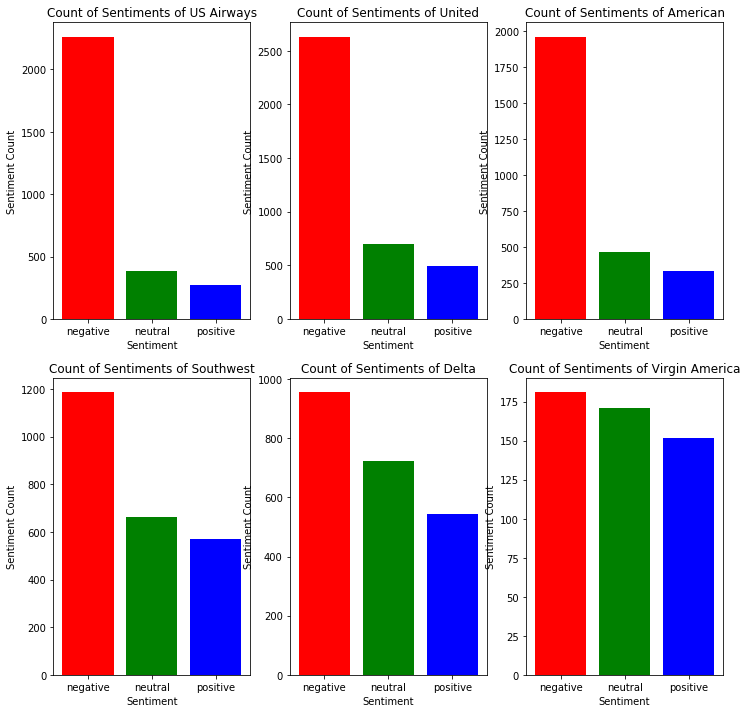

In [47]:
def plot_sub_sentiment(airline):
    df1=df[df['airline']==airline]
    count=df1['airline_sentiment'].value_counts()
    index = [1,2,3]
    plt.bar(index,count,color=['red', 'green', 'blue'])
    plt.xticks(index,['negative','neutral','positive'])
    plt.ylabel('Sentiment Count')
    plt.xlabel('Sentiment')
    plt.title('Count of Sentiments of '+airline)
plt.figure(1,figsize=(12, 12))
plt.subplot(231)
plot_sub_sentiment('US Airways')
plt.subplot(232)
plot_sub_sentiment('United')
plt.subplot(233)
plot_sub_sentiment('American')
plt.subplot(234)
plot_sub_sentiment('Southwest')
plt.subplot(235)
plot_sub_sentiment('Delta')
plt.subplot(236)
plot_sub_sentiment('Virgin America')

We are going to remove undefined data here

In [0]:
df = df.drop(['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord'], axis = 1) 

Now we will remove unnecessary data

In [0]:
df = df.drop(['tweet_id', 'name', 'retweet_count', 'tweet_created', 'tweet_location', 'user_timezone'], axis = 1)

Let us rearrange the dataframe

In [0]:
df = df [['text', 'airline', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence']]

In [42]:
df.head()

,text,airline,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence
0,@VirginAmerica What @dhepburn said.,Virgin America,neutral,1.0000,NaN,NaN
1,@VirginAmerica plus you've added commercials t...,Virgin America,positive,0.3486,NaN,0.0000
2,@VirginAmerica I didn't today... Must mean I n...,Virgin America,neutral,0.6837,NaN,NaN
3,@VirginAmerica it's really aggressive to blast...,Virgin America,negative,1.0000,Bad Flight,0.7033
4,@VirginAmerica and it's a really big bad thing...,Virgin America,negative,1.0000,Can't Tell,1.0000


Let us find out the commonly used words in the tweets

In [0]:
from wordcloud import WordCloud,STOPWORDS

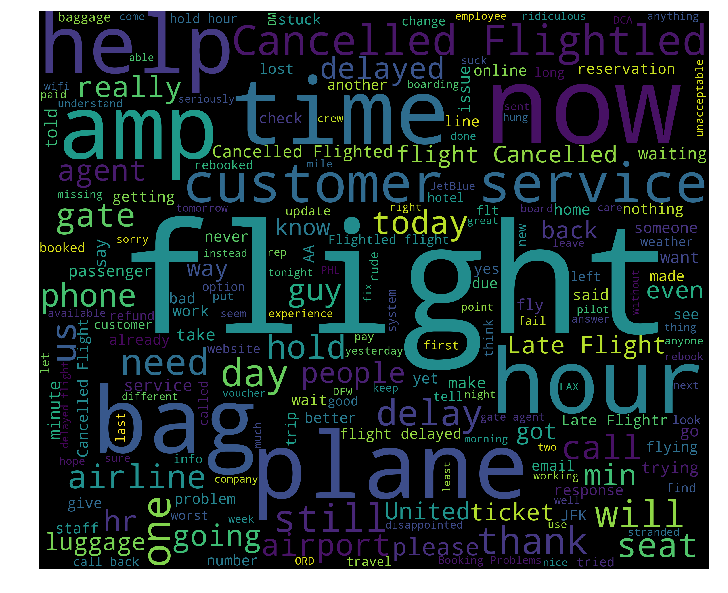

In [50]:
new_df=df[df['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

As we can see, words such as 'flight', 'help' 'cancelled', 'delayed', 'bag', 'late' seem to contibute to tweets with negative sentiment.

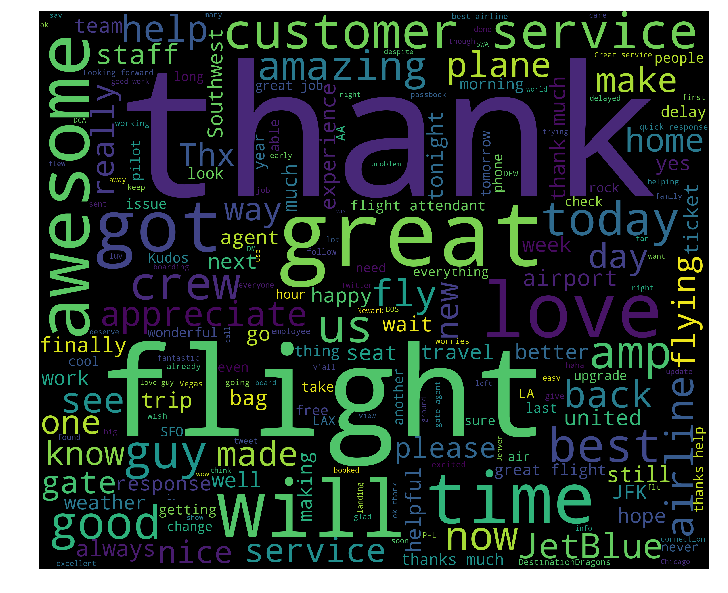

In [51]:
new_df=df[df['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

As we can see, words such as 'thank', 'awesome', 'great', 'amazing', 'love', 'best' seem to contibute to tweets with positive sentiment.

We can visualize that some pretty obvious words make it easy to distinguish between positive and negative sentiment tweets.

Our data exploration ends here. The next step will be preprocessing the data in order to make the learning process smoother.

In [0]:
import re
import nltk
from nltk.corpus import stopwords

In [0]:
#Function to split raw tweet text into meaningful words

def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

In [0]:
#Applying above function on our dataset

df['clean_tweet']=df['text'].apply(lambda x: tweet_to_words(x))

In [0]:
df['sentiment']=df['airline_sentiment'].apply(lambda x: 0 if x=='negative' else 1)

In [0]:
import sklearn
from sklearn.model_selection import train_test_split

We will now split the data into training and testing set in 80:20 ratio

In [0]:
train, test = train_test_split(df, test_size=0.2, random_state=15)

Creating separate features for training and testing sets that contain only the clean tweets

In [0]:
train_clean_tweet=[]
for tweet in train['clean_tweet']:
    train_clean_tweet.append(tweet)
test_clean_tweet=[]
for tweet in test['clean_tweet']:
    test_clean_tweet.append(tweet)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(train_clean_tweet)
test_features=v.transform(test_clean_tweet)

Specifying the different classifier models we will be using

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [0]:
Classifiers = [
    LogisticRegression(C=0.000000001,solver='lbfgs',max_iter=100),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    ]

In [116]:
dense_features = train_features.toarray()
dense_test = test_features.toarray()
Accuracy = []
Model = []
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features, train['sentiment'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features, train['sentiment'])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred, test['sentiment'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+'is '+str(accuracy))  

Accuracy of LogisticRegressionis 0.6215846994535519


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy of SVCis 0.6215846994535519
Accuracy of DecisionTreeClassifieris 0.7435109289617486
Accuracy of RandomForestClassifieris 0.8176229508196722


Let us visualize our model results as bar graphs

Text(0.5, 1.0, 'Accuracies of Models')

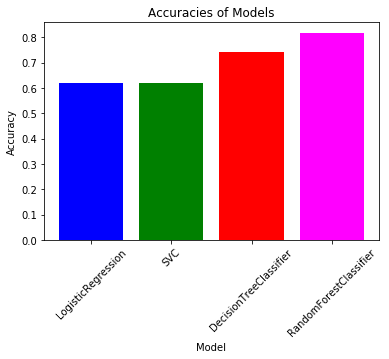

In [117]:
Index = [1,2,3,4]
plt.bar(Index,Accuracy,color=['blue','green','red','magenta'])
plt.xticks(Index, Model,rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')

We can notice here, that with the example models with similar hyperparameters to those of the Kaggle kernels (eg: https://www.kaggle.com/jiashenliu/how-can-we-predict-the-sentiment-by-tweets), we get interesting results. Our benchmark Logistic Regression model performs quite poorly, likewise the SVM. Both the tree type classifiers: Decision Tree and Random Forests perform very well, like expected before.


Let us now tune in the hyperparameters and check the results.

In [128]:
dense_features = train_features.toarray()
dense_test = test_features.toarray()
Accuracy = []
Model = []
Classifiers = [LogisticRegression(C=0.01,solver='newton-cg',max_iter=200),
               RandomForestClassifier(n_estimators=200, max_features='log2', criterion='entropy')]
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features, train['sentiment'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features, train['sentiment'])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred, test['sentiment'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+'is '+str(accuracy))

Accuracy of LogisticRegressionis 0.7889344262295082
Accuracy of RandomForestClassifieris 0.8292349726775956


Text(0.5, 1.0, 'Accuracies of Models')

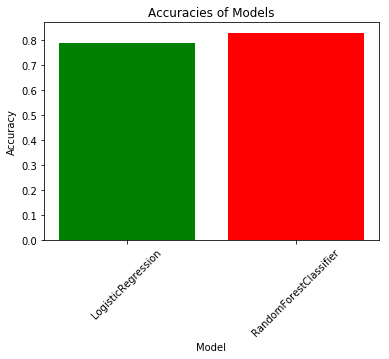

In [129]:
Index = [1,2]
plt.bar(Index,Accuracy,color=['green','red'])
plt.xticks(Index, Model,rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')